In [3]:
""" Monte Carlo Baseline Simulation
Author: Kevin Dick & James R. Green
---
Simulates the random drawing of a variable number of digits
and compute precision and recall. When repeated for several
itrations, the average performance establishes the baseline
performance expected by a random predictor.
"""
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.stats.api as sms
import pickle

def draw_digits(num_guess):
    """ generates a list of randomly selected digits.
        Input: <int> num_guess, the number of draws
        Output: <list>, the list of those draws
    """
    return np.random.randint(0,10,num_guess).tolist()

def calc_metrics(actual,pred, verbose=False):
    """ computes the precision and recall between
        the selected digits and those drawn.
        Input: <list> actual, the list of target digits
               <list> pred, the list of predicted digits
               <bool> verbose, (optional) increase verbosity
        Output: <2-tuple> (recall, prec):
                <float> recall, the computed recall
                <float> prec, the computed precision
    """
    TP = 0
    for p in pred:
        for pos, a in enumerate(actual):
            if p == a:
                TP += 1 
                del actual[pos] # Can't match to the same actual digit more than once
                break # Don't want to match this prediction again
        
    FP = len(pred) - TP # subtract the number of matches from the total # pred
    FN = len(actual) # any 'actual' remaining are FN
  
    recall = TP/(TP+FN)
    prec = TP/(TP+FP)
    if verbose:
        print('TP: {}, FN: {}, FP: {}'.format(TP, FN, FP))
        print('Recall: {}/({} + {})'.format(TP, TP, FN))
        print('Precision: {}/({} + {})'.format(TP, TP, FP))
    return (recall, prec)


In [8]:
# Example application.
Y = 3  # number of actual digits in the image
X = 10  # number of predicted digits

#Create an image with Y digits
actual = draw_digits(Y)

# Make X guesses
pred = draw_digits(X)

print("Actual digits:", actual)
print("Predicted digits: ", pred)

#Compute performance metrics
rec,prec = calc_metrics(actual,pred)

print("Recall = {0:.3f}\nPrecision = {1:.3f}".format(rec, prec))


Actual digits: [8, 0, 8]
Predicted digits:  [7, 9, 0, 9, 3, 4, 3, 7, 2, 3]
Recall = 0.333
Precision = 0.100


In [9]:
def monte_carlo_simulation(num_actual, num_predicted, num_iter=1000, verbose=False):
    """ performs the Monte Carlo simulations for a given number of 
        iterations.
        Input: <int> num_actual, the number of target digits
               <int> num_predicted, the number of predicted digits
               <int> num_iter, (optional) number of repeated interations (default: 1000)
               <bool> verbose, (optional) increase verbosity (default: False)
        Output: <4-tuple> (avg_recall, avg_prec, rec_CI, prec_CI)
                <float> avg_recall, the average recall
                <float> avg_prec, the average precision
                <2-tuple> rec_CI, lower and upper recall values of 95% CI
                <2-tuple> prec_CI, lower and upper precision values of 95% CI
    """
    total_recall = 0.0
    total_prec   = 0.0
    recs         = []
    precs        = []
    for i in range(num_iter):
        # Create a target label with Y digits
        actual = draw_digits(num_actual)
        
        # Make X guesses
        pred = draw_digits(num_predicted)
        
        # Compute performance metrics
        rec,prec = calc_metrics(actual,pred)
        recs.append(rec)
        precs.append(prec)
        
        if verbose: print('r={},p={}'.format(rec, prec))
        total_recall += rec
        total_prec += prec
    
    avg_recall = total_recall / float(num_iter)
    avg_prec   = total_prec / float(num_iter)
    rec_CI  = sms.DescrStatsW(recs).tconfint_mean()
    prec_CI = sms.DescrStatsW(precs).tconfint_mean()
    if verbose: print("Avg Recall = {0:.3f}\nAvg Precision = {1:.3f}".format(avg_recall, avg_prec))
    return (avg_recall, avg_prec, rec_CI, prec_CI)

In [10]:
avg_recs  = []
avg_precs = []
low_rec   = []
high_rec  = []
low_prec  = []
high_prec = []
for i in range(1,100):
    r, p, r_CI, p_CI = monte_carlo_simulation(3, i)
    avg_recs.append(r)
    avg_precs.append(p)
    
    # Ensure that the CIs are positive differences
    low_rec.append(r - r_CI[0])
    high_rec.append(r_CI[1] - r)
    low_prec.append(p - p_CI[0])
    high_prec.append(p_CI[1] - p)

Text(0.5, 1.0, 'Monte Carlo Simulation of Average Precision & Recall')

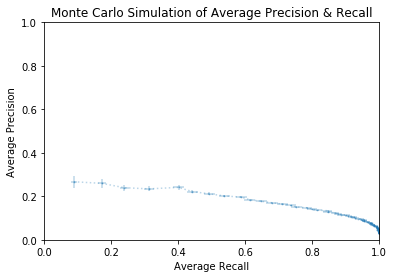

In [11]:
# Plot the results!
plt.errorbar(avg_recs, avg_precs,
             xerr=[low_rec, high_rec],
             yerr=[low_prec, high_prec],
             marker='o', markersize=1,
             linestyle='dotted', alpha=0.3)

plt.xlabel('Average Recall')
plt.ylabel('Average Precision')
plt.xlim([0,1])
plt.ylim([0,1])
plt.title('Monte Carlo Simulation of Average Precision & Recall')
#plt.savefig('mc-sim.pdf')
#with open('mc-data.pkl', 'wb') as f: pickle.dump({'avg_recs':avg_recs, 'avg_precs':avg_precs,'xerr':[low_rec, high_rec], 'yerr':[low_prec, high_prec]}, f)

In [12]:
# Generate baseline estimates for a variable number of actual digits per image: [1,20]
curves = {}
for j in  [1,10,20,30,40,50,60,70,80,90,100]:
    avg_recs  = []
    avg_precs = []
    low_rec   = []
    high_rec  = []
    low_prec  = []
    high_prec = []
    for i in range(1,100):
        r, p, r_CI, p_CI = monte_carlo_simulation(j, i)
        avg_recs.append(r)
        avg_precs.append(p)
    
        # Ensure that the CIs are positive differences
        low_rec.append(r - r_CI[0])
        high_rec.append(r_CI[1] - r)
        low_prec.append(p - p_CI[0])
        high_prec.append(p_CI[1] - p)
    
    curves[j] = {'avg_recs':avg_recs, 
                 'avg_precs':avg_precs,
                 'xerr':[low_rec, high_rec], 
                 'yerr':[low_prec, high_prec], 
                 'label':'y={}'.format(j)}

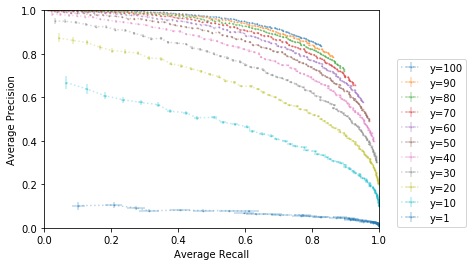

In [13]:
for j in sorted(curves, reverse=True):
    plt.errorbar(curves[j]['avg_recs'], curves[j]['avg_precs'],
             xerr=curves[j]['xerr'],
             yerr=curves[j]['yerr'],
             label=curves[j]['label'],
             marker='o', markersize=1,
             linestyle='dotted', alpha=0.3)
plt.xlabel('Average Recall')
plt.ylabel('Average Precision')
plt.xlim([0,1])
plt.ylim([0,1])
#plt.legend()
plt.legend(bbox_to_anchor=(1.04,0.8), loc="upper left")
#plt.title('Monte Carlo Simulation for a Varying Number of Digits')
#plt.savefig('mc-sim-multiple-corrected-by10.pdf', bbox_inches="tight")